In [1]:
library(ape)
library(jsonlite)
library(sitePath)
library(aplot)
library(ggplot2)
library(ggrepel)
library(RColorBrewer)
suppressPackageStartupMessages(library(treeio))
suppressPackageStartupMessages(library(ggtree))

TREES_DIR <- "Trees"
PLOTS_DIR <- "Plots"
STRUCTURES_DIR <- "Structures"
ANTIGENICITY <- "Antigenicity"

H1N1_HA_NAME <- "H1N1_HA"
H3N2_HA_NAME <- "H3N2_HA"

Warning message:
"package 'jsonlite' was built under R version 4.0.2"
Registered S3 method overwritten by 'treeio':
  method     from
  root.phylo ape 



### 1. H1N1 HA

In [2]:
plotOutDir <- file.path(PLOTS_DIR, H1N1_HA_NAME)
dir.create(plotOutDir, showWarnings = FALSE)

In [3]:
treeDir <- file.path(TREES_DIR, H1N1_HA_NAME)

tree <- read.tree(file.path(treeDir, "RAxML_bestTree.PROTGAMMAGTR"))
tree <- drop.tip(tree, "MK615591")
tree <- addMSA(tree, msaPath = file.path(treeDir, "aligned.fasta"), msaFormat = "fasta")

In [4]:
paths <- lineagePath(tree, 0.01)
mutations <- fixationSites(paths)

In [5]:
snpTracing <- fixationPath(mutations)
tipClusters <- as.list(snpTracing)

Warning message:
"`mutate_()` is deprecated as of dplyr 0.7.0.
Please use `mutate()` instead.
See vignette('programming') for more help
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated."


In [6]:
x <- read.csv(file.path(ANTIGENICITY, "H1N1_antigenRelation"), header = FALSE, sep = "\t")
x[which(x[, 3] == "Min"), 3] <- 0
oddsRatio <- as.double(x[, 3])
x[, 3] <- oddsRatio / (oddsRatio + 1)

In [7]:
antiMatrix <- reshape2::dcast(x, V1 ~ V2, value.var = "V3", fill = 1)
rownames(antiMatrix) <- antiMatrix[, "V1"]
antiMatrix <- antiMatrix[, -1]

In [8]:
missingCol <- setdiff(rownames(antiMatrix), colnames(antiMatrix))
missingRow <- setdiff(colnames(antiMatrix), rownames(antiMatrix))

for (i in missingCol) {
    antiMatrix[, i] <- 1
}

for (i in missingRow) {
    antiMatrix[i, ] <- 1
}

In [9]:
for (seqName in intersect(rownames(antiMatrix), colnames(antiMatrix))) {
    antiMatrix[seqName, seqName] <- 0
}

In [10]:
antiMatrix <- antiMatrix[sort(rownames(antiMatrix)), sort(colnames(antiMatrix))]

In [11]:
fit1D <- cmdscale(antiMatrix, eig = TRUE, k = 1)

In [12]:
x <- lapply(names(tipClusters), function(grp) {
    tips <- tipClusters[[grp]]
    tipNames <- as.phylo(tree)[["tip.label"]][tips]
    tipNames <- tipNames[tipNames %in% rownames(fit1D[["points"]])]
    pc1 <- fit1D[["points"]][tipNames, , drop = FALSE]
    data.frame("Mapped" = pc1, "tipNum" = grp)
})
x <- do.call(rbind, x)

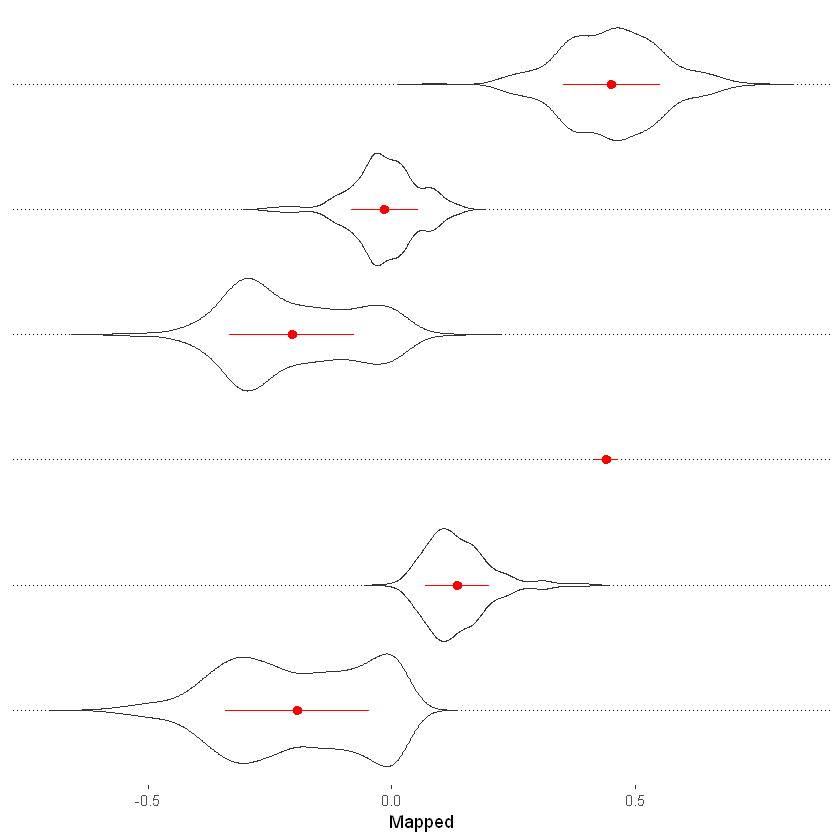

In [13]:
p1 <- ggplot(x, aes(Mapped, tipNum)) +
    geom_violin(trim = FALSE, scale = "width") +
    stat_summary(fun.data = function(x) {
       m <- mean(x)
       ymin <- m-sd(x)
       ymax <- m+sd(x)
       return(c(y=m,ymin=ymin,ymax=ymax))
    }, color = "red") +
    theme(
        axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank(),
        panel.background = element_rect(fill = "white"),
        panel.grid.major.y = element_line(colour = "black", linetype = 3)
    )
p1

Warning message:
"`tbl_df()` is deprecated as of dplyr 1.0.0.
Please use `tibble::as_tibble()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated."


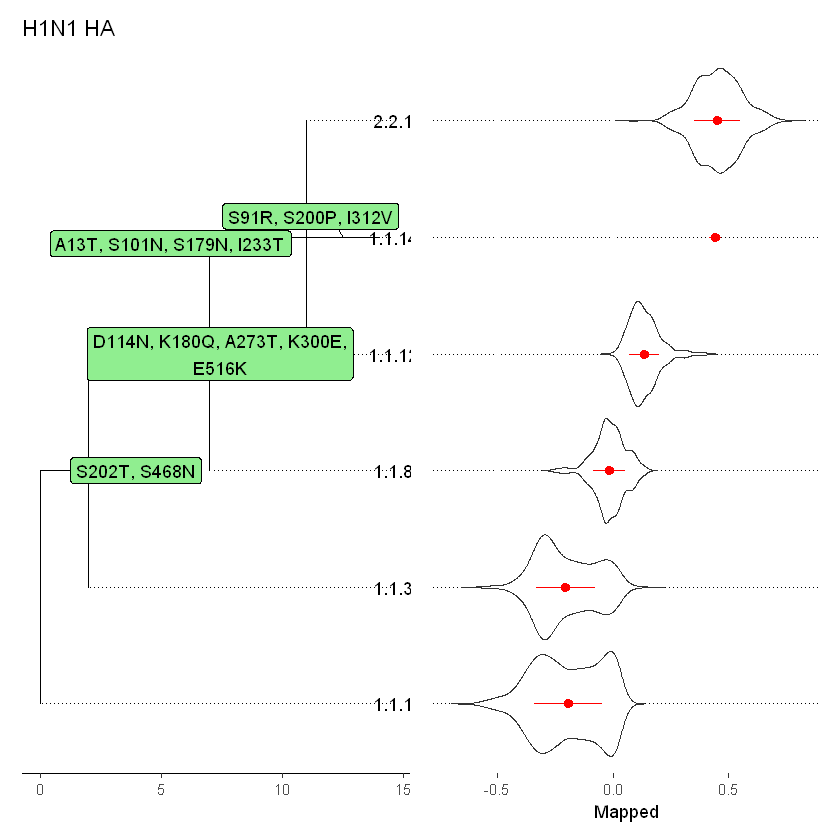

In [14]:
p <- plot(snpTracing) + ggtitle("H1N1 HA")

p <- p1 %>% insert_left(p)
p

ggsave(filename = file.path(plotOutDir, "snpTracing.pdf"), plot = p, device = "pdf", width = 14, height = 7)

In [15]:
write.csv(antiMatrix, file.path(ANTIGENICITY, "H1N1_matrix.csv"))

In [16]:
fit2D <- cmdscale(antiMatrix, eig = TRUE, k = 2)

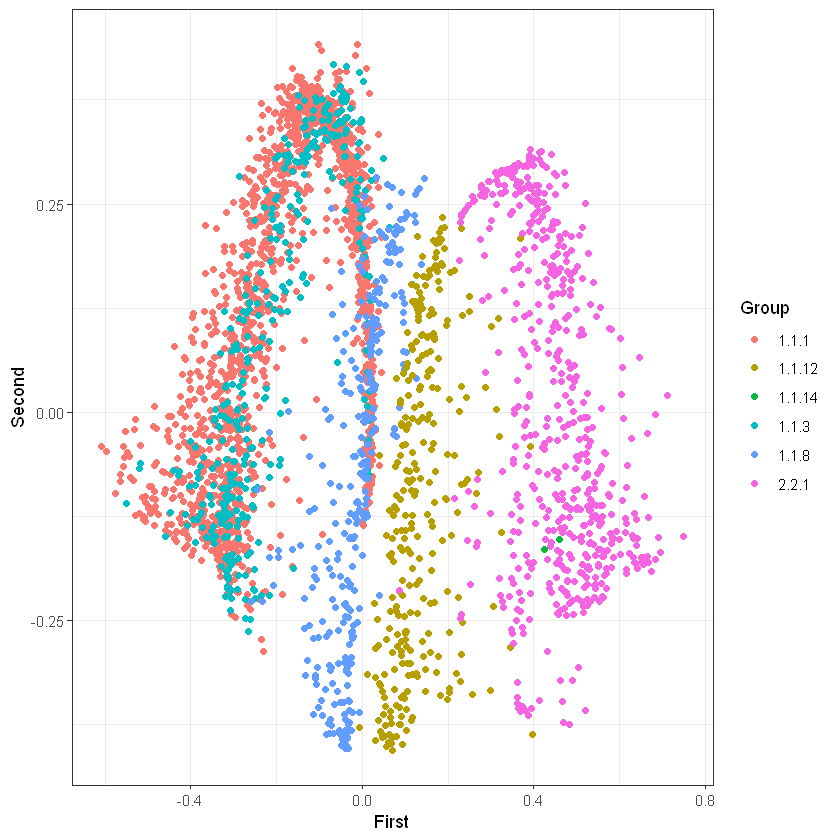

In [17]:
y <- lapply(names(tipClusters), function(grp) {
    tips <- tipClusters[[grp]]
    tipNames <- as.phylo(tree)[["tip.label"]][tips]
    tipNames <- tipNames[tipNames %in% rownames(fit2D[["points"]])]
    pc1 <- fit2D[["points"]][tipNames, , drop = FALSE]
    data.frame("First" = pc1[, 1], "Second" = pc1[, 2], "Group" = rep(grp, length(tips)))
})
y <- do.call(rbind, y)

y[["Group"]] <- as.factor(y[["Group"]])

p <- ggplot(y, aes(First, Second, color = Group)) + 
    geom_point() +
    theme_bw()
p

ggsave(filename = file.path(plotOutDir, "mds_dot.pdf"), plot = p, device = "pdf", width = 7, height = 7)

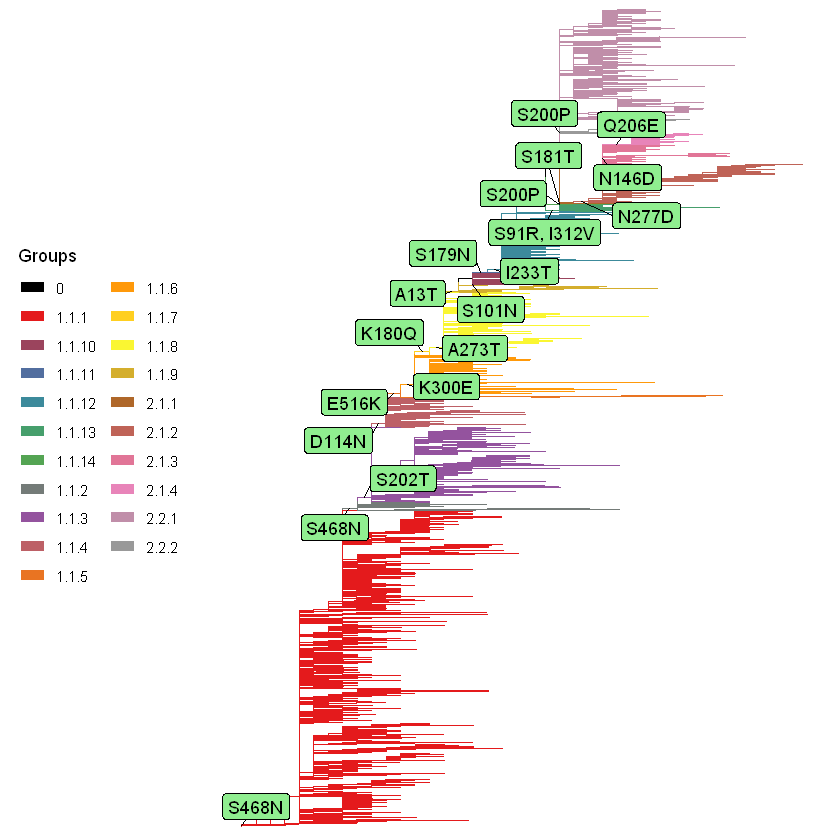

In [18]:
p <- plot(mutations) +
    theme(legend.position = "left")
p

ggsave(
    filename = file.path(plotOutDir, "cluster.pdf"), 
    plot = p,
    width = 10,
    height = 8
)

In [19]:
pred <- as.data.frame(mutations)
write.csv(pred, file.path(plotOutDir, "sitePath.csv"), row.names = FALSE)

### 2. H3N2 HA

In [20]:
plotOutDir <- file.path(PLOTS_DIR, H3N2_HA_NAME)
dir.create(plotOutDir, showWarnings = FALSE)

In [21]:
treeDir <- file.path(TREES_DIR, H3N2_HA_NAME)

tree <- read.tree(file.path(treeDir, "RAxML_bestTree.PROTGAMMAGTR"))
tree <- drop.tip(tree, "AB284320")
tree <- addMSA(tree, msaPath = file.path(treeDir, "aligned.fasta"), msaFormat = "fasta")

In [22]:
paths <- lineagePath(tree, 0.01)
mutations <- fixationSites(paths)

In [23]:
x <- read.csv(file.path(ANTIGENICITY, "H3N2_antigenRelation"), header = FALSE, sep = "\t")
x[which(x[, 3] == "Min"), 3] <- 0
oddsRatio <- as.double(x[, 3])
x[, 3] <- oddsRatio / (oddsRatio + 1)

In [24]:
antiMatrix <- reshape2::dcast(x, V1 ~ V2, value.var = "V3", fill = 1)
rownames(antiMatrix) <- antiMatrix[, "V1"]
antiMatrix <- antiMatrix[, -1]

In [25]:
missingCol <- setdiff(rownames(antiMatrix), colnames(antiMatrix))
missingRow <- setdiff(colnames(antiMatrix), rownames(antiMatrix))

for (i in missingCol) {
    antiMatrix[, i] <- 1
}

for (i in missingRow) {
    antiMatrix[i, ] <- 1
}

In [26]:
for (seqName in intersect(rownames(antiMatrix), colnames(antiMatrix))) {
    antiMatrix[seqName, seqName] <- 0
}

In [27]:
antiMatrix <- antiMatrix[sort(rownames(antiMatrix)), sort(colnames(antiMatrix))]

In [28]:
write.csv(antiMatrix, file.path(ANTIGENICITY, "H3N2_matrix.csv"))

In [29]:
fit1D <- cmdscale(antiMatrix, eig = TRUE, k = 1)

In [30]:
snpTracing <- fixationPath(mutations)
tipClusters <- as.list(snpTracing)

In [31]:
x <- lapply(names(tipClusters), function(grp) {
    tips <- tipClusters[[grp]]
    tipNames <- as.phylo(tree)[["tip.label"]][tips]
    tipNames <- tipNames[tipNames %in% rownames(fit1D[["points"]])]
    pc1 <- fit1D[["points"]][tipNames, , drop = FALSE]
    data.frame("Mapped" = pc1, "tipNum" = grp)
})
x <- do.call(rbind, x)

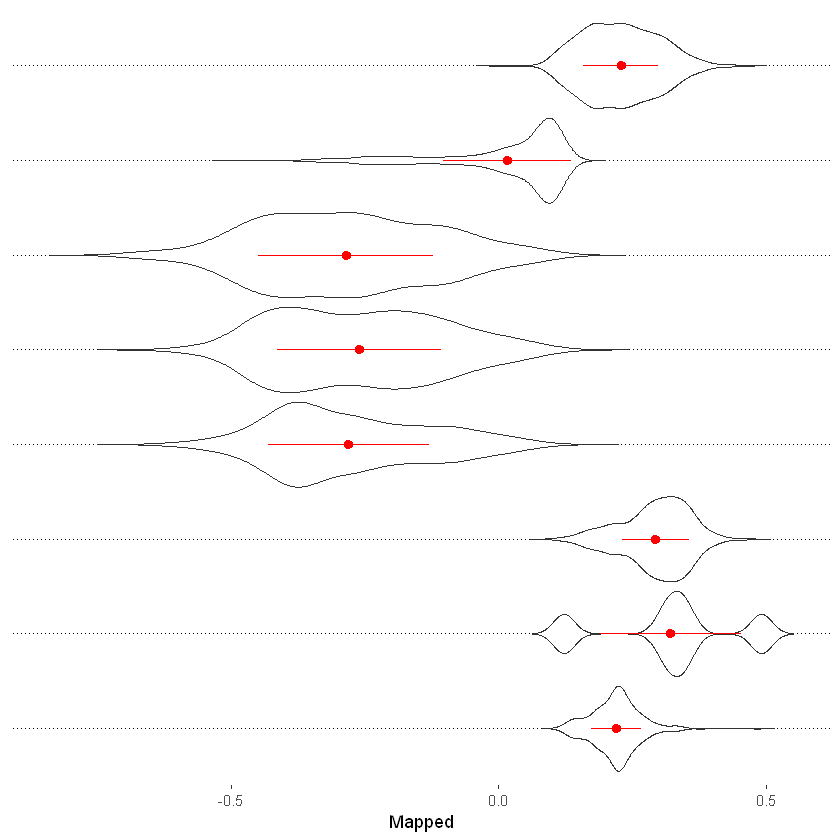

In [32]:
p1 <- ggplot(x, aes(Mapped, tipNum)) +
    geom_violin(trim = FALSE, scale = "width") +
    stat_summary(fun.data = function(x) {
       m <- mean(x)
       ymin <- m-sd(x)
       ymax <- m+sd(x)
       return(c(y=m,ymin=ymin,ymax=ymax))
    }, color = "red") +
    theme(
        axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank(),
        panel.background = element_rect(fill = "white"),
        panel.grid.major.y = element_line(colour = "black", linetype = 3)
    )
p1

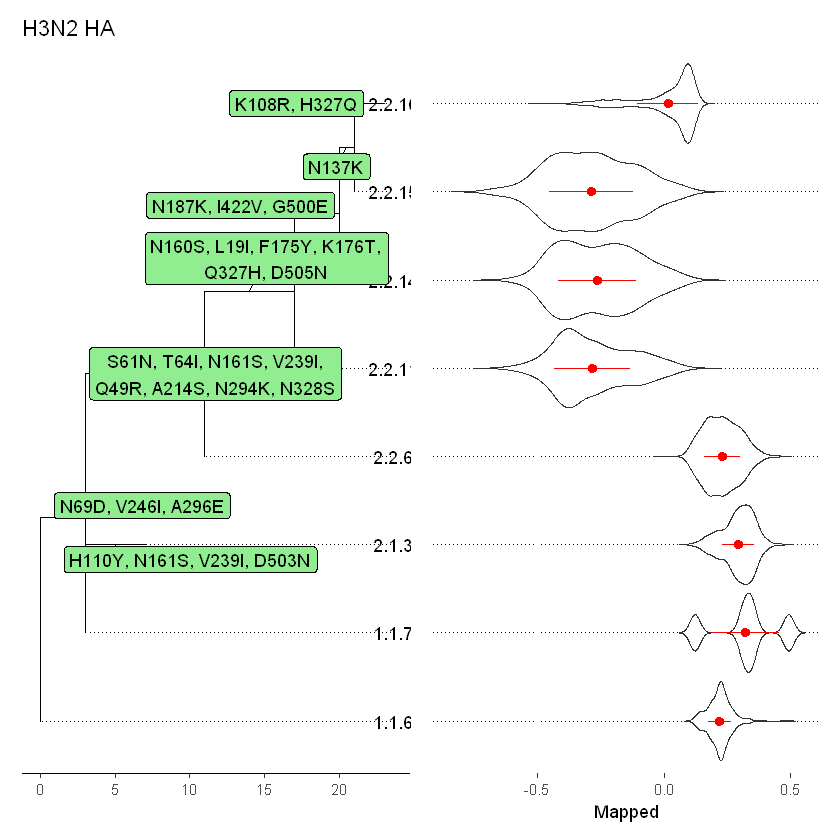

In [33]:
p <- plot(snpTracing) + ggtitle("H3N2 HA")

p <- p1 %>% insert_left(p)
p

ggsave(filename = file.path(plotOutDir, "snpTracing.pdf"), plot = p, device = "pdf", width = 14, height = 7)

In [34]:
fit2D <- cmdscale(antiMatrix, eig = TRUE, k = 2)

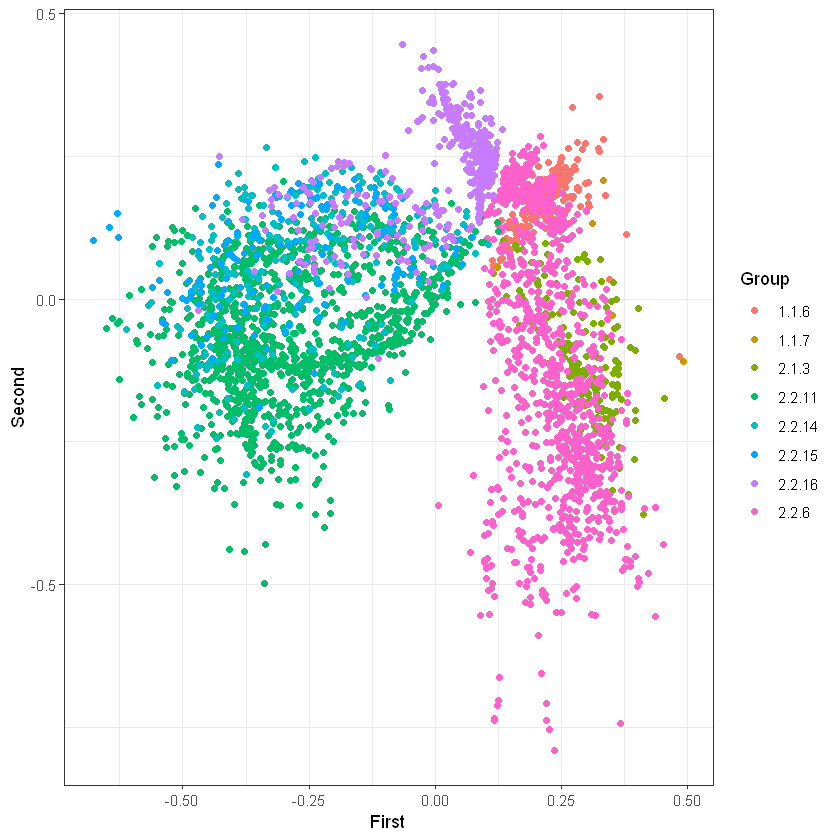

In [35]:
y <- lapply(names(tipClusters), function(grp) {
    tips <- tipClusters[[grp]]
    tipNames <- as.phylo(tree)[["tip.label"]][tips]
    tipNames <- tipNames[tipNames %in% rownames(fit2D[["points"]])]
    pc1 <- fit2D[["points"]][tipNames, , drop = FALSE]
    data.frame("First" = pc1[, 1], "Second" = pc1[, 2], "Group" = rep(grp, length(tips)))
})
y <- do.call(rbind, y)

y[["Group"]] <- as.factor(y[["Group"]])

p <- ggplot(y, aes(First, Second, color=Group)) + 
    geom_point() +
    theme_bw()
p

ggsave(filename = file.path(plotOutDir, "mds_dot.pdf"), plot = p, device = "pdf", width = 7, height = 7)

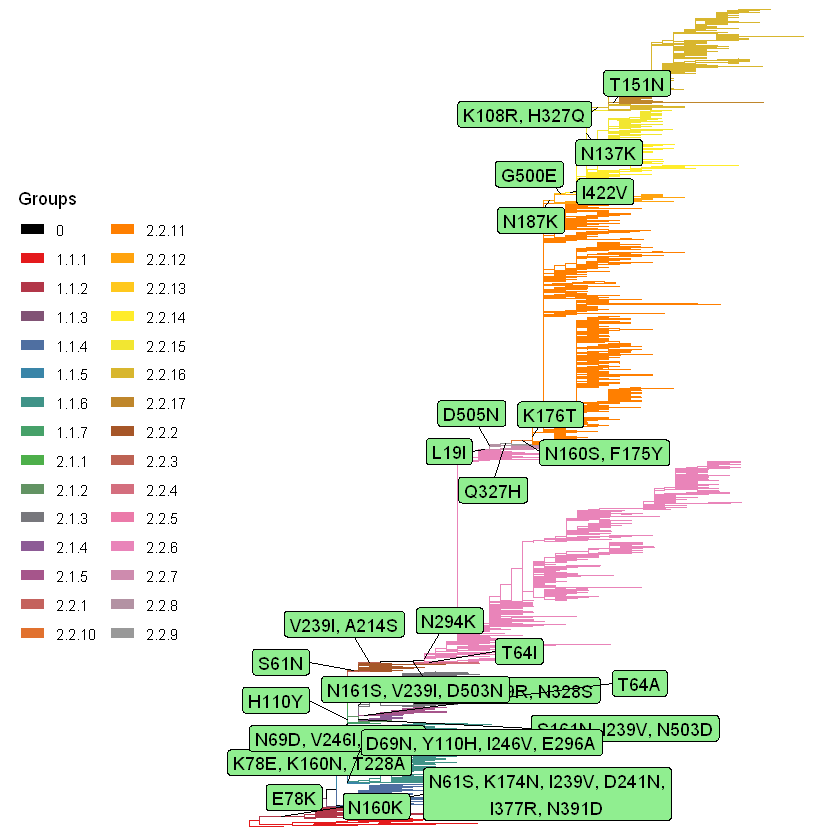

In [36]:
p <- plot(mutations)
p

ggsave(
    filename = file.path(plotOutDir, "cluster.pdf"), 
    plot = p,
    width = 10,
    height = 8
)

In [37]:
pred <- as.data.frame(mutations)
write.csv(pred, file.path(plotOutDir, "sitePath.csv"), row.names = FALSE)